<a href="https://colab.research.google.com/github/ernclb4/mta-visualization/blob/master/MTADataCollector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
from scipy.ndimage.interpolation import shift
from collections import defaultdict
import seaborn as sns
import sys

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def datelist(startdate):
    """
    For a given Saturday, make a list of dates for the 14 previous Saturdays
    Modify the range() function to get more or less weeks
    """
    week_list = [startdate + ((timedelta(days=-7))*i) for i in range(1)]
    clean_weeks = [i.strftime('%y%m%d') for i in week_list]
    return clean_weeks

In [0]:
#For now we are importing the last 4 months in 2020
start20 = datetime(2020, 2, 22)
weeks_to_import = datelist(start20)

def loadturndata(date):
    # Build the filename
    strdate = str(date)
    filename = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'+strdate+'.txt'

    # Read in the csv
    df = pd.read_csv(filename)
    return df

def loadturnlist(dates):
    """
    We'll iterarte through the list of weeks to create dataframes using loadturndata and then concat together into one dataframe
    """
    data = pd.DataFrame()
    x = []
    b = 0
    for i in dates:
        b += 1
        print(str((b/len(dates))*100) + 'Done')
        df = (loadturndata(i))
        x.append(df)
    data = pd.concat(x)
    return data

raw = loadturnlist(weeks_to_import)
raw.to_pickle('/raw_turnstile_data.pkl')
raw = pd.read_pickle('/raw_turnstile_data.pkl')



100.0Done


In [0]:
# Rename columns
df = raw.rename(columns=lambda x: x.strip().lower())

# Concat date and time and convert to datetime object
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime_clean'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df['datetime']]

# Add some helpful date-part columns
df['year'] = [x.year for x in df['datetime_clean']]
df['weekday'] = df[['datetime_clean']].apply(lambda x: datetime.strftime(x['datetime_clean'], '%A'), axis=1)

# Create group ID for distinct turnstiles
df['group'] = df['c/a'].astype(str) + \
              df['unit'].astype(str) + \
              df['scp'].astype(str) + \
              df['station'].astype(str) + \
              df['linename'].astype(str) + \
              df['division'].astype(str) + \
              df['year'].astype(str)

# Map 'group' string to integer id
groups = set(df['group'])

In [0]:
def groups_dict(groups):
    group_dict = defaultdict(int)
    for i in enumerate(list(groups)):
        group_dict[i[1]] = i[0]

    return group_dict

In [0]:
group_id_dict = groups_dict(groups)

df['group_id'] = [group_id_dict[x] for x in df['group']]

# Create station ID for distinct stations
df['station_line'] = df['station'].astype(str) + \
                df['linename'].astype(str)

# Sort values by group id and date to find diff in turnstile counts from prev row
df.sort_values(['group_id','datetime_clean'], inplace=True)
df.reset_index(drop=True)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,datetime_clean,year,weekday,group,group_id,station_line
0,N191,R335,00-05-01,BEACH 67 ST,A,IND,02/15/2020,03:00:00,REGULAR,0,0,02/15/2020 03:00:00,2020-02-15 03:00:00,2020,Saturday,N191R33500-05-01BEACH 67 STAIND2020,0,BEACH 67 STA
1,N191,R335,00-05-01,BEACH 67 ST,A,IND,02/15/2020,07:00:00,REGULAR,0,0,02/15/2020 07:00:00,2020-02-15 07:00:00,2020,Saturday,N191R33500-05-01BEACH 67 STAIND2020,0,BEACH 67 STA
2,N191,R335,00-05-01,BEACH 67 ST,A,IND,02/15/2020,11:00:00,REGULAR,0,0,02/15/2020 11:00:00,2020-02-15 11:00:00,2020,Saturday,N191R33500-05-01BEACH 67 STAIND2020,0,BEACH 67 STA
3,N191,R335,00-05-01,BEACH 67 ST,A,IND,02/15/2020,15:00:00,REGULAR,0,0,02/15/2020 15:00:00,2020-02-15 15:00:00,2020,Saturday,N191R33500-05-01BEACH 67 STAIND2020,0,BEACH 67 STA
4,N191,R335,00-05-01,BEACH 67 ST,A,IND,02/15/2020,19:00:00,REGULAR,0,0,02/15/2020 19:00:00,2020-02-15 19:00:00,2020,Saturday,N191R33500-05-01BEACH 67 STAIND2020,0,BEACH 67 STA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206178,N025,R102,01-00-04,125 ST,ACBD,IND,02/21/2020,07:00:00,REGULAR,9535127,4018548,02/21/2020 07:00:00,2020-02-21 07:00:00,2020,Friday,N025R10201-00-04125 STACBDIND2020,4916,125 STACBD
206179,N025,R102,01-00-04,125 ST,ACBD,IND,02/21/2020,11:00:00,REGULAR,9535692,4018660,02/21/2020 11:00:00,2020-02-21 11:00:00,2020,Friday,N025R10201-00-04125 STACBDIND2020,4916,125 STACBD
206180,N025,R102,01-00-04,125 ST,ACBD,IND,02/21/2020,15:00:00,REGULAR,9535996,4018758,02/21/2020 15:00:00,2020-02-21 15:00:00,2020,Friday,N025R10201-00-04125 STACBDIND2020,4916,125 STACBD
206181,N025,R102,01-00-04,125 ST,ACBD,IND,02/21/2020,19:00:00,REGULAR,9536460,4018933,02/21/2020 19:00:00,2020-02-21 19:00:00,2020,Friday,N025R10201-00-04125 STACBDIND2020,4916,125 STACBD


In [0]:
def find_diff_prev_row(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    col_diff = abs(col_array - col_array_shifted)

    return col_diff

In [0]:
df['entries_diff'] = find_diff_prev_row(df['entries'])
df['exit_diff'] = find_diff_prev_row(df['exits'])

In [0]:
# Identify first rows for each group partition to use as mask when setting invalid values to nan
def find_first_rows_groups(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    first_row_mask = col_array != col_array_shifted

    return first_row_mask

In [0]:
df['first_row_group'] = find_first_rows_groups(df['group_id'])

# Make entries_diff and exit_diff nan when first row in group or negative value
df.loc[df['first_row_group'], 'entries_diff'] = None
df.loc[df['entries_diff'] < 0, 'entries_diff'] = None

df.loc[df['first_row_group'], 'exit_diff'] = None
df.loc[df['exit_diff'] < 0, 'exit_diff'] = None

In [0]:
def find_outliers(df_series, multiple_IQR):
    """
    For a series of numerical values, remove the zeros and identify the upper outliers
    to return a mask for all outliers in series
    """
    non_zeros = df_series.replace(0, None)

    adjusted_IQR = (non_zeros.quantile(.75) - non_zeros.quantile(.25)) * multiple_IQR
    outlier_lim = non_zeros.quantile(.75) + adjusted_IQR
    print(outlier_lim)

    outliers = [True if x > outlier_lim else False for x in df_series]

    outlier_count = sum(outliers)
    all_data_count = len(df_series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count / all_data_count, 6)))

    return outliers

In [0]:
print('Entries Outliers')
df['entries_outlier'] = find_outliers(df['entries_diff'], 5)

print('\n Exit Outliers')
df['exit_outlier'] = find_outliers(df['exit_diff'], 5)

Entries Outliers
1244.0
1255 outliers identified: 0.006087 of all data

 Exit Outliers
917.0
2836 outliers identified: 0.013755 of all data


In [0]:
print('All Data Len:', len(df))
print('All Data Len:', len(df))

clean_df = df.loc[(~df['entries_outlier'])].copy()
print('Excluding Outliers Len:', len(clean_df))

print('Keeping', round(len(clean_df)/len(df), 6))

print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

All Data Len: 206183
All Data Len: 206183
Excluding Outliers Len: 204928
Keeping 0.993913
Null entry diffs 4917
Null exit diffs 4917
Clean Data len: 204928


In [0]:
clean_df.dropna(subset = ['entries_diff', 'exit_diff'], how='any', inplace=True)

print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

thrown_away = len(df) - len(clean_df)
print("We're throwing away {} data points - about {} of the total".format(thrown_away, round(thrown_away/len(df), 4)))


Null entry diffs 0
Null exit diffs 0
Clean Data len: 200011
We're throwing away 6172 data points - about 0.0299 of the total


In [0]:
## Find average daily entry volume by station
clean_df['week'] = [x.isocalendar()[1] for x in clean_df['datetime_clean']]
clean_df['hour'] = [x.hour for x in clean_df['datetime_clean']]

In [0]:
def timebin(hour):
    if hour == 0:
        return 6
    if hour <= 4:
        return 1
    if hour <= 8:
        return 2
    if hour <= 12:
        return 3
    if hour <= 16:
        return 4
    if hour <= 20:
        return 5
    if hour <= 24:
        return 6


hourgroups = {6: '8pm - 12am',
              1: '12am - 4am',
              2: '4am - 8am',
              3: '8am - 12pm',
              4: '12pm - 4pm',
              5: '4pm - 8pm'}

wkdaynbr = {'Friday': 5,
            'Monday': 1,
            'Saturday': 6,
            'Sunday': 0,
            'Thursday': 4,
            'Tuesday': 2,
            'Wednesday': 3}

clean_df['timegroup'] = clean_df['hour'].apply(timebin)
clean_df['timegroupstr'] = clean_df['timegroup'].map(hourgroups)
clean_df['wkdaynbr'] = clean_df['weekday'].map(wkdaynbr)

print(clean_df.head())
clean_df.to_pickle('/cleaned_turnstile_data.pkl')

        c/a  unit       scp  ... timegroup timegroupstr wkdaynbr
71477  N191  R335  00-05-01  ...         2    4am - 8am        6
71478  N191  R335  00-05-01  ...         3   8am - 12pm        6
71479  N191  R335  00-05-01  ...         4   12pm - 4pm        6
71480  N191  R335  00-05-01  ...         5    4pm - 8pm        6
71481  N191  R335  00-05-01  ...         6   8pm - 12am        6

[5 rows x 28 columns]


station_line
34 ST-HERALD SQBDFMNQRW        77334.571429
42 ST-PORT AUTHACENQRS1237W    57916.000000
GRD CNTRL-42 ST4567S           57449.428571
34 ST-PENN STAACE              55041.000000
FULTON ST2345ACJZ              42767.000000
TIMES SQ-42 ST1237ACENQRSW     42603.571429
14 ST-UNION SQLNQR456W         37714.000000
JKSN HT-ROOSVLTEFMR7           37079.000000
34 ST-PENN STA123ACE           34676.142857
59 ST COLUMBUSABCD1            33666.714286
CANAL STJNQRZ6W                33150.000000
86 ST456                       30881.857143
W 4 ST-WASH SQABCDEFM          30746.714286
47-50 STS ROCKBDFM             30583.428571
PATH NEW WTC1                  30193.428571
72 ST123                       28652.571429
FLUSHING-MAIN7                 28123.857143
57 ST-7 AVNQRW                 25516.428571
JAY ST-METROTECACF             25477.857143
96 ST123                       25393.714286
Name: entries_diff, dtype: float64
<class 'pandas.core.series.Series'>


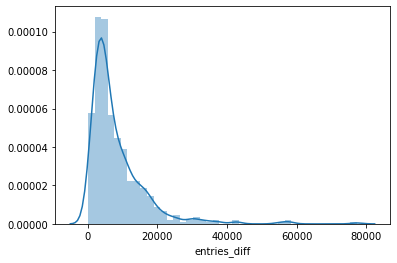

In [0]:
# Find daily average entries per station
stations_day = clean_df.groupby(['station_line', 'date']).sum()
stations_day.reset_index(inplace=True)

daily_avg = stations_day.groupby('station_line')['entries_diff'].mean()
daily_avg.sort_values(ascending=False, inplace=True)
sns.distplot(daily_avg, hist=True, kde=True)

print(daily_avg.head(20))
print(type(daily_avg))

pd.Series.to_csv(daily_avg, '/DailyAverageEntrance.csv')
pd.Series.to_csv(clean_df, '/AllCleanDataFrame.csv')